<h1>Homework #2 - Template Based Chord Recognition</h1>

In [303]:
import os
import numpy as np
from scipy import signal
import librosa
import libfmp.b
from matplotlib import pyplot as plt

<h2>Configurations</h2>

In [304]:
sample_rate=22050
window_length=4096
hop_size=2048
norm_input='2'
norm_output='max'
norm_threshold=0.0001
smooth_filter_length=20
smooth_filter_window_type='hanning'
down_sampling_factor=10
feature_normalization=True
feature_compression=False
feature_smoothing=False
feature_downsample=False

<h2>Features processing functions</h2>

In [305]:
def compress_feature_sequence(feature_sequence, gamma=0.1):
    """ TODO

    Args:

    Returns:

    """

    compressed_feature_sequence = np.log(1 + gamma * np.abs(feature_sequence) ** 2)
    return compressed_feature_sequence

def normalize_feature_sequence(feature_sequence, norm='2', v=None):
    """Normalizes the columns of a feature sequence

    Args:
        feature_sequence: Feature sequence
        v: Used instead of normalization below `norm_threshold`. If None, uses unit vector for given norm

    Returns:
        feature_sequence_norm: Normalized feature sequence
    """

    K, N = feature_sequence.shape
    feature_sequence_norm = np.zeros((K, N))

    if v is None:
        v = np.ones(K, dtype=np.float64)

    if norm == '1':
        for n in range(N):
            s = np.sum(np.abs(feature_sequence[:, n]))
            if s > norm_threshold:
                feature_sequence_norm[:, n] = feature_sequence[:, n] / s
            else:
                feature_sequence_norm[:, n] = v / K

    if norm == '2':
        for n in range(N):
            s = np.sqrt(np.sum(feature_sequence[:, n] ** 2))
            if s > norm_threshold:
                feature_sequence_norm[:, n] = feature_sequence[:, n] / s
            else:
                feature_sequence_norm[:, n] = v / np.sqrt(K)

    if norm == 'max':
        for n in range(N):
            s = np.max(np.abs(feature_sequence[:, n]))
            if s > norm_threshold:
                feature_sequence_norm[:, n] = feature_sequence[:, n] / s
            else:
                feature_sequence_norm[:, n] = v

    return feature_sequence_norm

def smooth_feature_sequence(feature_sequence):
    """
    Args:
        X: Feature sequence
        Fs: Frame rate of `X`
        filt_len: Length of smoothing filter
        down_sampling: Downsampling factor
        w_type: Window type of smoothing filter

    Returns:
        X_smooth: Smoothed and downsampled feature sequence
        Fs_feature: Frame rate of `X_smooth`
    """

    filter_kernel = signal.get_window(smooth_filter_window_type, smooth_filter_length)
    # use expand dims to add one dimension to the window, from (L, ) to (1,L)
    expanded_filter_kernel = np.expand_dims(filter_kernel, axis=0)
    # mode='same' guarantees that the final length of the convolution is equal to the length of feature_sequence
    smoothed_feature_sequence = signal.convolve(feature_sequence, expanded_filter_kernel, mode='same') / smooth_filter_length
    return smoothed_feature_sequence

def downsample_feature_sequence(feature_sequence):
    """ TODO

    Args:

    Returns:

    """

    downsampled_feature_sequence = feature_sequence[:, ::down_sampling_factor]
    downsampled_fs = sample_rate / down_sampling_factor
    return downsampled_feature_sequence, downsampled_fs

<h2>Template-based chord recognition steps</h2>

In [306]:
def load_audio(wav_file_path: str):
    """ Load WAV audio file from a system path

    Args:
        wav_file_path (str): System path to a WAV file

    Returns:
        audio_file: (np.ndarray): Audio signal
        audio_duration (float): Duration in seconds of the audio signal
    """

    audio_file, Fs = librosa.load(wav_file_path, sr=sample_rate)
    audio_duration = audio_file.shape[0] / sample_rate

    return audio_file, audio_duration

def chroma_representation(audio_file):
    """ TODO

    Args:

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """

    # Compute chroma features with STFT
    chroma_features = librosa.stft(audio_file, n_fft=window_length, hop_length=hop_size, pad_mode='constant', center=True)
    chroma_features = np.abs(chroma_features) ** 2

    if feature_compression:
        compress_feature_sequence(chroma_features)

    chroma_features = librosa.feature.chroma_stft(S=chroma_features, sr=sample_rate, tuning=0, norm=None, hop_length=hop_size, n_fft=window_length)
    chroma_feature_rate = sample_rate / hop_size

    return chroma_features, chroma_feature_rate

def generate_triads_templates():
    """Generate chord templates of major and minor triads

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """

    template_cmaj = np.array([[1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]]).T
    template_cmin = np.array([[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]]).T
    c_triads_templates = np.concatenate((template_cmaj, template_cmin), axis=1)
    num_chord = 12 * c_triads_templates.shape[1]
    triads_templates = np.ones((12, num_chord))
    for shift in range(12):
        shifted_templates = np.roll(c_triads_templates, shift, axis=0)
        triads_templates[:, shift::12] = shifted_templates

    return triads_templates

def generate_chord_labels():
    """Generate chord labels for major and minor triads

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + 'm' for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    return chord_labels

def pre_processing(chroma_features, triads_templates):
    """ TODO

    Args:

    Returns:

    """

    processed_chroma_feature = chroma_features
    processed_triads_templates = triads_templates

    if feature_normalization:
        processed_chroma_feature = normalize_feature_sequence(processed_chroma_feature, norm=norm_input)
        processed_triads_templates = normalize_feature_sequence(triads_templates, norm=norm_input)

    if feature_smoothing:
        processed_chroma_feature = smooth_feature_sequence(processed_chroma_feature)

    if feature_downsample:
        processed_chroma_feature, downsampled_rate = downsample_feature_sequence(processed_chroma_feature)
        return processed_chroma_feature, processed_triads_templates, downsampled_rate

    return processed_chroma_feature, processed_triads_templates

def pattern_matching(chroma_features, triads_template):
    """ TODO

    Args:

    Returns:

    """

    chord_similarity = np.matmul(triads_template.T, chroma_features)

    return chord_similarity

def post_processing(chord_similarity):
    """ TODO

    Args:

    Returns:

    """

    processed_chord_similarity = chord_similarity

    if feature_normalization:
        processed_chord_similarity = normalize_feature_sequence(processed_chord_similarity, norm=norm_output)

    return processed_chord_similarity

def recognition_result(chord_similarity, triads_templates):
    """ TODO

    Args:

    Returns:

    """
    chord_labels = generate_chord_labels()
    chord_max = (chord_similarity == chord_similarity.max(axis=0))
    chord_labels_indexes = np.arange(24)
    recognized_chord_labels = []
    for i in range(chord_max.shape[1]):
        recognized_chord_label_index = chord_labels_indexes[chord_max[:, i]][0]
        recognized_chord_labels = recognized_chord_labels + [chord_labels[recognized_chord_label_index]]

    return recognized_chord_labels, chord_max, chord_labels

<h2>Template-based chord recognition implementation</h2>

In [307]:
def compute_template_based_chord_recognition(audio_file_path):
    """ TODO

    Args:

    Returns:

    """

    # Load audio file
    audio_file, audio_duration = load_audio(audio_file_path)

    # Compute chromagram
    chroma_features, chroma_feature_rate = chroma_representation(audio_file)

    # Generate triads template
    triads_template = generate_triads_templates()

    # Pre-processing
    if feature_downsample:
        chroma_features, triads_template, chroma_feature_rate = pre_processing(chroma_features, triads_template)
    else:
        chroma_features, triads_template = pre_processing(chroma_features, triads_template)

    # Pattern matching
    chord_similarity = pattern_matching(chroma_features, triads_template)

    # Post-processing
    chord_similarity = post_processing(chord_similarity)

    # Chord recognition
    recognized_chord_labels, chord_max, chord_labels = recognition_result(chord_similarity, triads_template)

    return recognized_chord_labels, chord_max, chord_labels, chord_similarity, chroma_features, chroma_feature_rate, triads_template, audio_file, audio_duration

<h2>Perform template-based chord recognition and plot results</h2>

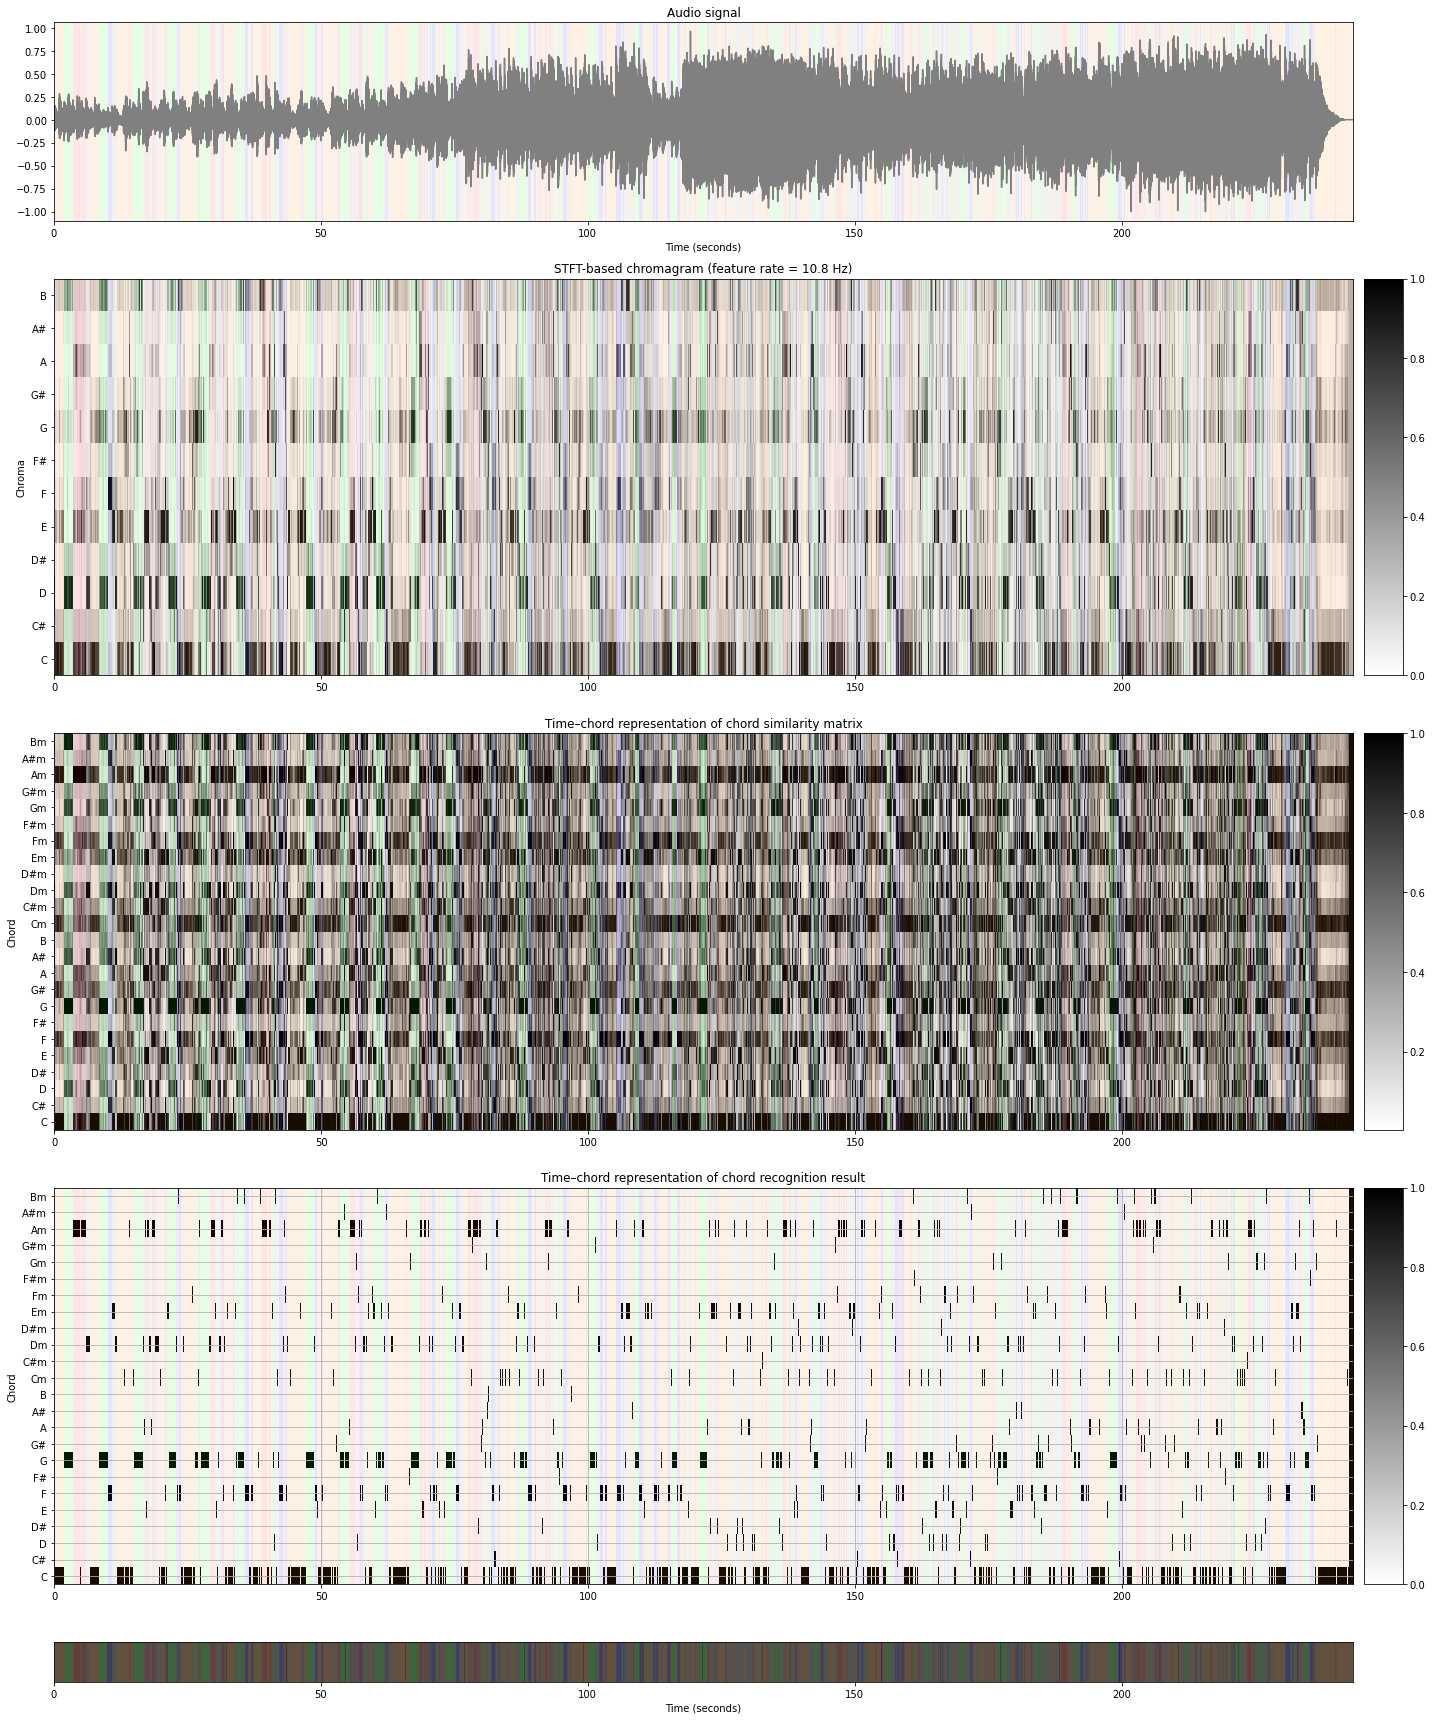

In [309]:
# Perform chords recognition
audio_file_path = os.path.join('data', 'wav', 'Beatles_LetItBe.wav')
recognized_chord_labels, chord_max, chord_labels, chord_similarity, chroma_features, chroma_feature_rate, triads_template, audio_file, audio_duration = compute_template_based_chord_recognition(audio_file_path)

# Annotations
time_frames_number = len(recognized_chord_labels)
time_axis = np.arange(time_frames_number) / chroma_feature_rate
annotations = []
for i in range(1, time_frames_number):
    start = time_axis[i - 1]
    end = time_axis[i]
    annotations = annotations + [(start, end, recognized_chord_labels[i - 1])]

color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1]}

# Figure configuration
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(5, 2, figsize=(20, 24), gridspec_kw={'width_ratios': [1, 0.03], 'height_ratios': [1.5, 3, 3, 3, 0.3]})

# Plot audio signal
libfmp.b.plot_signal(audio_file, sample_rate, ax=ax[0,0], title='Audio signal')
libfmp.b.plot_segments_overlay(annotations, ax=ax[0,0], time_max=audio_duration, print_labels=False, colors=color_ann, alpha=0.1)
ax[0,1].axis('off')

# PLot chromagram
title = 'STFT-based chromagram (feature rate = %0.1f Hz)' % chroma_feature_rate
libfmp.b.plot_chromagram(chroma_features, ax=[ax[1,0], ax[1,1]], Fs=chroma_feature_rate, clim=[0, 1], xlabel='', title=title)
libfmp.b.plot_segments_overlay(annotations, ax=ax[1,0], time_max=audio_duration,  print_labels=False, colors=color_ann, alpha=0.1)

# Plot similarity matrix
title = 'Time–chord representation of chord similarity matrix'
libfmp.b.plot_matrix(chord_similarity, ax=[ax[2, 0], ax[2, 1]], Fs=chroma_feature_rate, title=title, ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange(len(chord_labels)))
ax[2, 0].set_yticklabels(chord_labels)
libfmp.b.plot_segments_overlay(annotations, ax=ax[2, 0], time_max=audio_duration, print_labels=False, colors=color_ann, alpha=0.1)

# Plot chord recognition results
title = 'Time–chord representation of chord recognition result'
libfmp.b.plot_matrix(chord_max, ax=[ax[3, 0], ax[3, 1]], Fs=chroma_feature_rate, title=title, ylabel='Chord', xlabel='')
ax[3, 0].set_yticks(np.arange(len(chord_labels)))
ax[3, 0].set_yticklabels(chord_labels)
ax[3, 0].grid()
libfmp.b.plot_segments_overlay(annotations, ax=ax[3, 0], time_max=audio_duration, print_labels=False, colors=color_ann, alpha=0.1)

libfmp.b.plot_segments(annotations, ax=ax[4, 0], time_max=audio_duration, print_labels=False, time_label='Time (seconds)', colors=color_ann,  alpha=0.3)
ax[4, 1].axis('off')

plt.tight_layout()